In [2]:
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras import models, layers, activations
from keras.layers import Conv2D, TimeDistributed, BatchNormalization, MaxPooling2D, Flatten, Bidirectional, Dense,Dropout,Flatten
from keras.callbacks import EarlyStopping

In [3]:
x_data = np.load('lip_x_data.npy')
y_data = np.load('lip_y_data.npy')
y_data = keras.utils.to_categorical(y_data,11)
print(x_data.shape, y_data.shape)

(3000, 27, 64, 64, 3) (3000, 11)


In [4]:
# Train과 Test 분리
X_train, X_test, Y_train, Y_test = train_test_split(x_data, y_data, test_size = 0.2, shuffle = True, stratify=y_data)
print("x_train: {}, X_test: {}".format(X_train.shape, X_test.shape))
print("Y_train: {}, Y_test: {}".format(Y_train.shape, Y_test.shape))

x_train: (2400, 27, 64, 64, 3), X_test: (600, 27, 64, 64, 3)
Y_train: (2400, 11), Y_test: (600, 11)


In [5]:
class deep_CNN_LSTM(keras.Model):
    def __init__(self, num_classes):
        super(deep_CNN_LSTM, self).__init__()
        self.conv1 = TimeDistributed(Conv2D(64, kernel_size=(5,5), activation = 'relu'))
        self.conv2 = TimeDistributed(Conv2D(32, kernel_size=(5,5), activation = 'relu'))
        self.conv3 = TimeDistributed(Conv2D(64, kernel_size=(5,5), activation = 'relu'))
        
        self.bilstm = layers.Bidirectional(layers.LSTM(256), merge_mode = 'concat')
        self.dense = layers.Dense(num_classes, activation = 'softmax')
        self.max_pool= TimeDistributed(MaxPooling2D(pool_size= (2,2)))
        self.dropout = layers.Dropout(0.2)
        self.flat= TimeDistributed(Flatten())
        
    def call(self, x):
        x = self.conv1(x)
        x = TimeDistributed(MaxPooling2D(pool_size= (2,2)))(x)
        x = self.dropout(x)
        x = BatchNormalization()(x)
        x = self.conv2(x)
        x = TimeDistributed(MaxPooling2D(pool_size= (2,2)))(x)
        x = self.dropout(x)
        x = BatchNormalization()(x)
        x = self.conv3(x)
        x = TimeDistributed(MaxPooling2D(pool_size= (2,2)))(x)
        x = self.dropout(x)
        x = BatchNormalization()(x)
        x = self.flat(x)
        x = self.bilstm(x)
        x = self.dense(x)
        return x

In [6]:
def get_model():
    return deep_CNN_LSTM(num_classes = 11)

In [7]:
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [8]:
model = get_model()
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
es = EarlyStopping(monitor = 'val_loss', patience = 10)
history = model.fit(X_train, Y_train, batch_size=32, epochs=100, verbose = 1, validation_data = (X_test, Y_test),callbacks = [es])

C:\Users\owner\anaconda3\envs\Lip\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/100
75/75 [==============================] - 521s 7s/step - loss: 2.3387 - accuracy: 0.1013 - val_loss: 2.3194 - val_accuracy: 0.1000
Epoch 2/100
75/75 [==============================] - 528s 7s/step - loss: 2.3101 - accuracy: 0.1071 - val_loss: 2.2887 - val_accuracy: 0.1150
Epoch 3/100
75/75 [==============================] - 530s 7s/step - loss: 2.2807 - accuracy: 0.1279 - val_loss: 2.2478 - val_accuracy: 0.1550
Epoch 4/100
75/75 [==============================] - 538s 7s/step - loss: 2.2494 - accuracy: 0.1454 - val_loss: 2.2294 - val_accuracy: 0.1417
Epoch 5/100
75/75 [==============================] - 538s 7s/step - loss: 2.2281 - accuracy: 0.1538 - val_loss: 2.2004 - val_accuracy: 0.1717
Epoch 6/100
75/75 [==============================] - 547s 7s/step - loss: 2.1539 - accuracy: 0.1871 - val_loss: 2.0272 - val_accuracy: 0.2233
Epoch 7/100
75/75 [==============================] - 536s 7s/step - loss: 1.9041 - accuracy: 0.2887 - val_loss: 1.7397 - val_accuracy: 0.3867
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


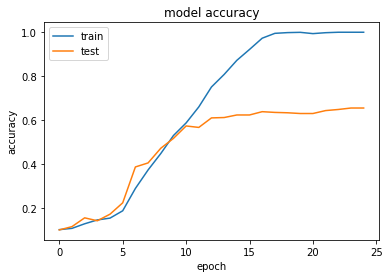

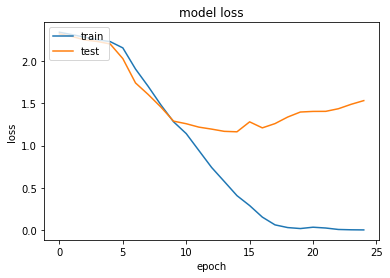

In [9]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()